In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


learning_rate = 0.001
batch_size = 10
epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [2]:
train_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\train"
test_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\test"
val_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\val"

path1 = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\annotation_rose.csv"
path2 = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\annotation_tulip.csv"
dfs = []
tmp = pd.read_csv(path1, sep=',', header=None, encoding='UTF-16') 
dfs.append(tmp)
tmp = pd.read_csv(path2, sep=',', header=None, encoding='UTF-16')
dfs.append(tmp)
df = pd.concat(dfs)
df.drop(1, axis=1, inplace=True)
df.rename(columns={0: 'absolute_way', 2: 'class_img'}, inplace=True)
df.reset_index(inplace=True)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

In [3]:
def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)


def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)



for i in range(576):
    load_train(df, train_path, i)
for i in range(720,1296):
    load_train(df, train_path, i)
for i in range(576,648):
    load_test(df,test_path,i)
for i in range(1296,1368):
    load_test(df,test_path,i)
for i in range(648,720):
    load_val(df,val_path,i)
for i in range(1368,1440):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
val_list = glob.glob(os.path.join(val_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)    

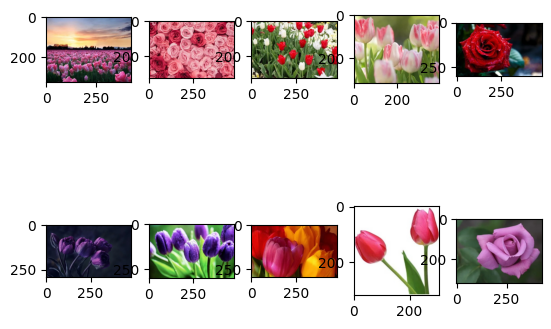

In [4]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()


In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
#Image Augmentation

In [7]:
#this code is for load our image sets
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'rose':
            label = 1
        elif label == 'tulip':
            label = 0

        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)


Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.6801284551620483, train loss : 0.5934495329856873
Epoch : 1, val_accuracy : 0.7361111044883728, val_loss : 0.5589028596878052
Epoch : 2, train accuracy : 0.75096195936203, train loss : 0.506723165512085
Epoch : 2, val_accuracy : 0.8166666626930237, val_loss : 0.4634818434715271
Epoch : 3, train accuracy : 0.7673079967498779, train loss : 0.4593140780925751
Epoch : 3, val_accuracy : 0.7916666865348816, val_loss : 0.4794328510761261
Epoch : 4, train accuracy : 0.7618592381477356, train loss : 0.4726935923099518
Epoch : 4, val_accuracy : 0.763888955116272, val_loss : 0.4169277250766754
Epoch : 5, train accuracy : 0.7887822389602661, train loss : 0.4427918791770935
Epoch : 5, val_accuracy : 0.8083333373069763, val_loss : 0.3807199001312256
Epoch : 6, train accuracy : 0.8038463592529297, train loss : 0.4249843955039978
Epoch : 6, val_accuracy : 0.7944443821907043, val_loss : 0.41513553261756897
Epoch : 7, train accuracy : 0.

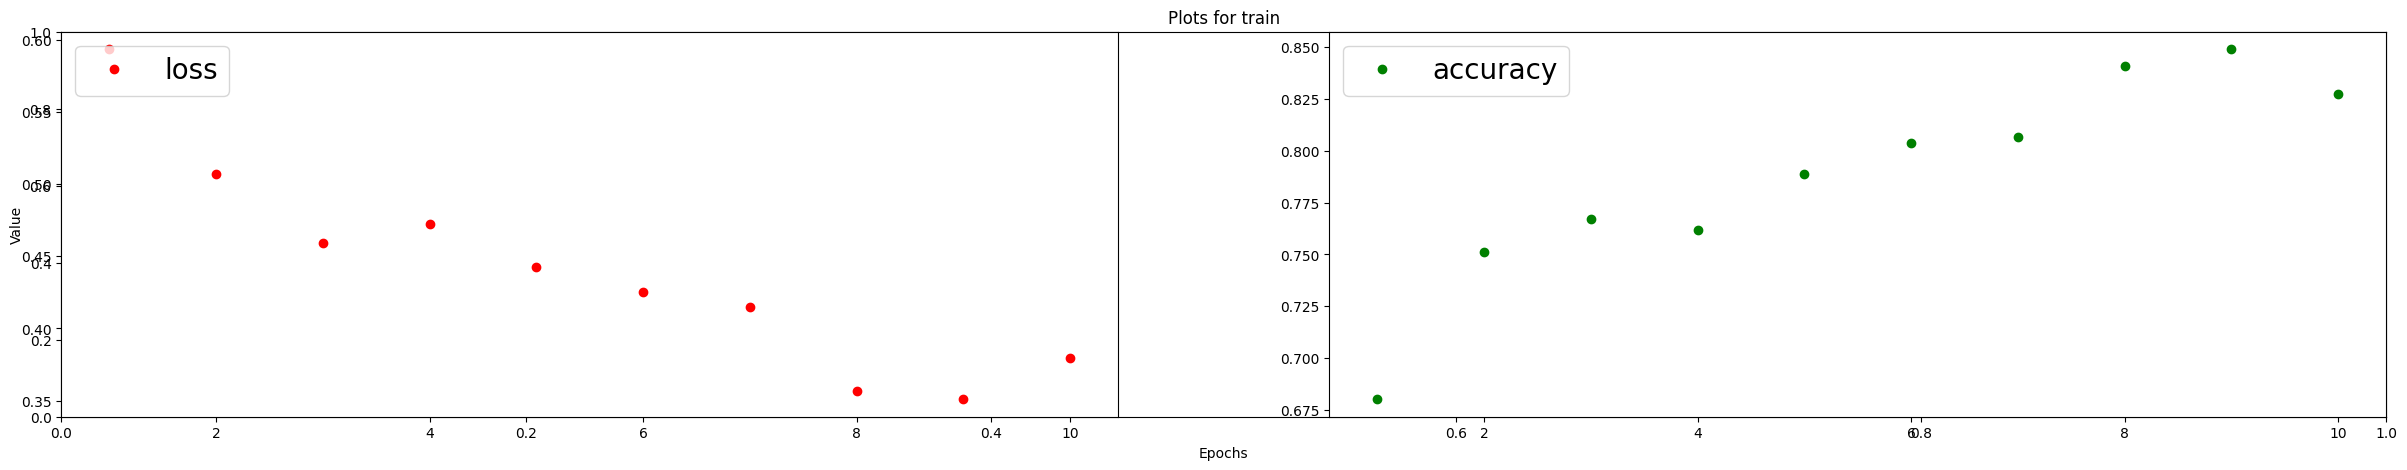

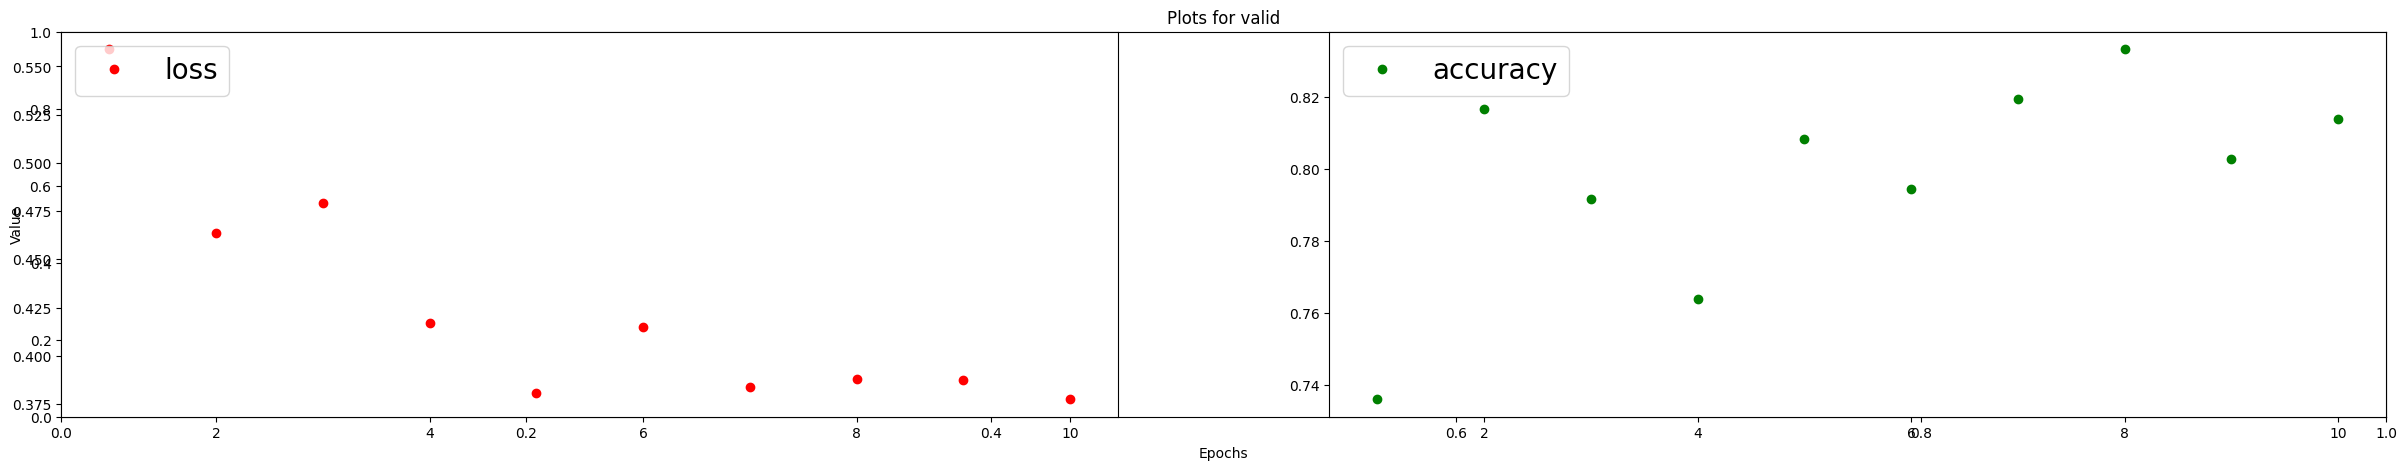

In [8]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)


            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.8355771899223328, train loss : 0.3468687832355499
Epoch : 1, val_accuracy : 0.8333333134651184, val_loss : 0.36584752798080444
Epoch : 2, train accuracy : 0.851282000541687, train loss : 0.326612651348114
Epoch : 2, val_accuracy : 0.9083332419395447, val_loss : 0.2704494893550873
Epoch : 3, train accuracy : 0.8695510029792786, train loss : 0.29520004987716675
Epoch : 3, val_accuracy : 0.8444443941116333, val_loss : 0.318291574716568
Epoch : 4, train accuracy : 0.8647434711456299, train loss : 0.32372644543647766
Epoch : 4, val_accuracy : 0.8999999165534973, val_loss : 0.27026641368865967
Epoch : 5, train accuracy : 0.8602564930915833, train loss : 0.3132443428039551
Epoch : 5, val_accuracy : 0.8666666150093079, val_loss : 0.3080199956893921
Epoch : 6, train accuracy : 0.8826921582221985, train loss : 0.2980336844921112
Epoch : 6, val_accuracy : 0.7972221970558167, val_loss : 0.45603448152542114
Epoch : 7, train accurac

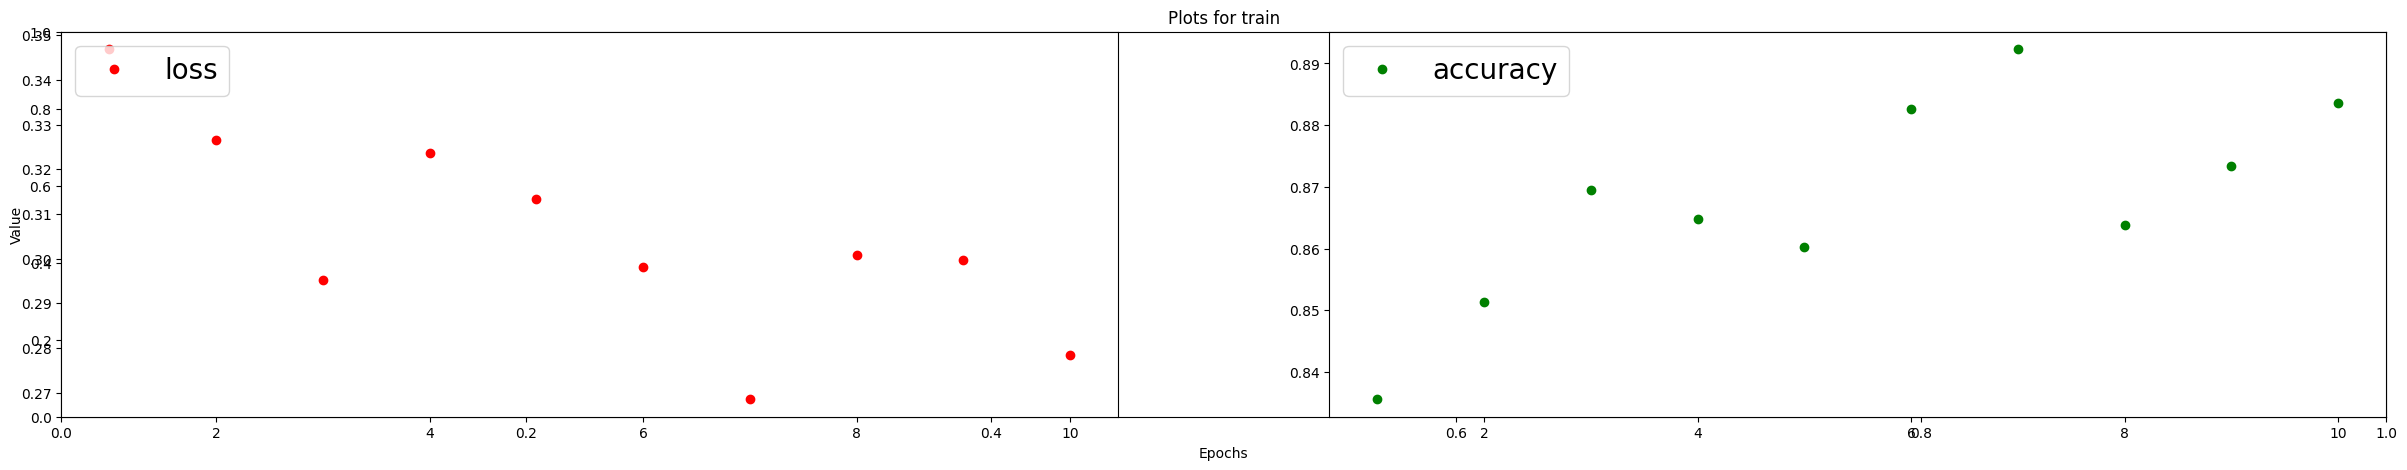

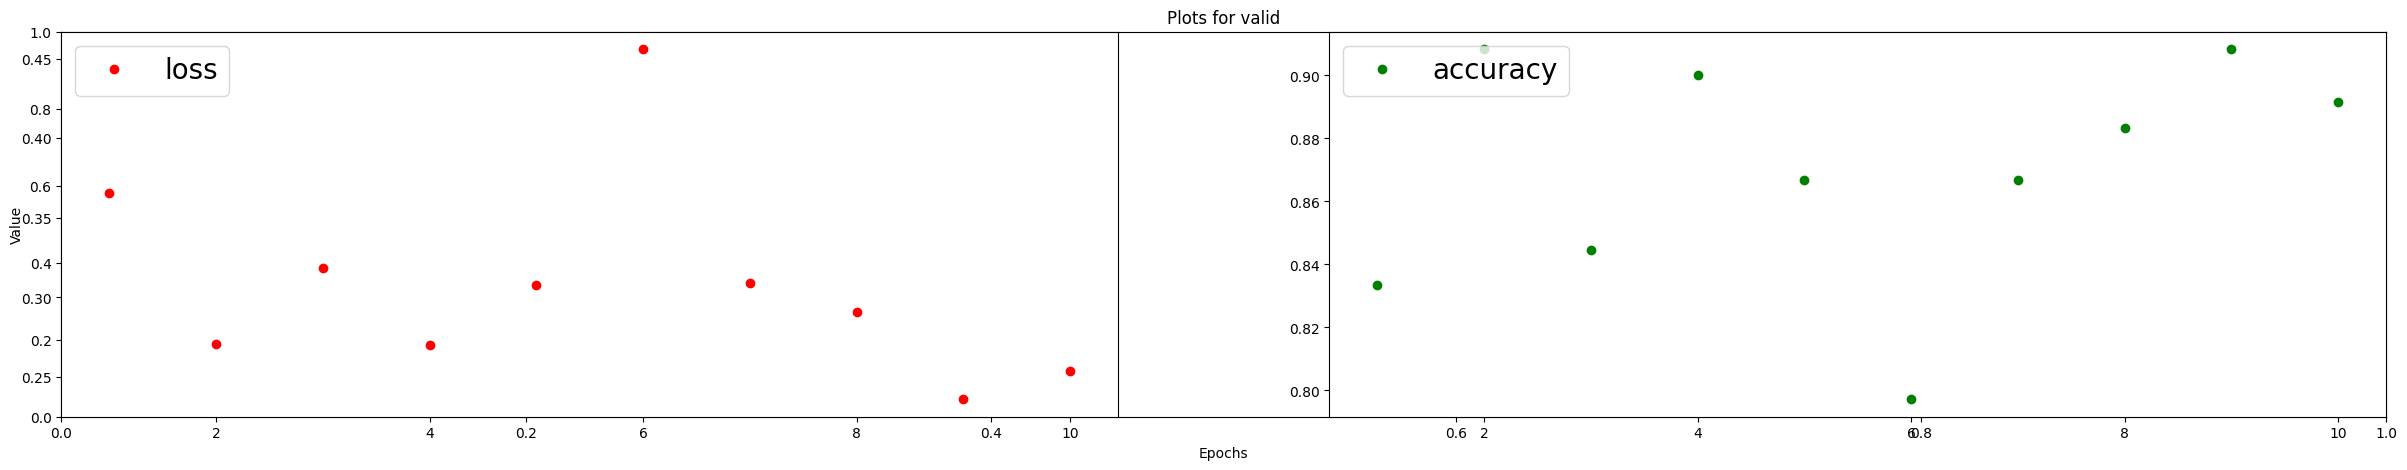

In [9]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.8682690858840942, train loss : 0.30008062720298767
Epoch : 1, val_accuracy : 0.8749999403953552, val_loss : 0.284384548664093
Epoch : 2, train accuracy : 0.8820509910583496, train loss : 0.2769555151462555
Epoch : 2, val_accuracy : 0.9083332419395447, val_loss : 0.26740941405296326
Epoch : 3, train accuracy : 0.8740383982658386, train loss : 0.28562629222869873
Epoch : 3, val_accuracy : 0.8749999403953552, val_loss : 0.2843921482563019
Epoch : 4, train accuracy : 0.8778842091560364, train loss : 0.2740621864795685
Epoch : 4, val_accuracy : 0.8722221851348877, val_loss : 0.39625996351242065
Epoch : 5, train accuracy : 0.8666666746139526, train loss : 0.3001821041107178
Epoch : 5, val_accuracy : 0.8833332657814026, val_loss : 0.24437610805034637
Epoch : 6, train accuracy : 0.8701920509338379, train loss : 0.28778669238090515
Epoch : 6, val_accuracy : 0.8833332657814026, val_loss : 0.3242783546447754
Epoch : 7, train accu

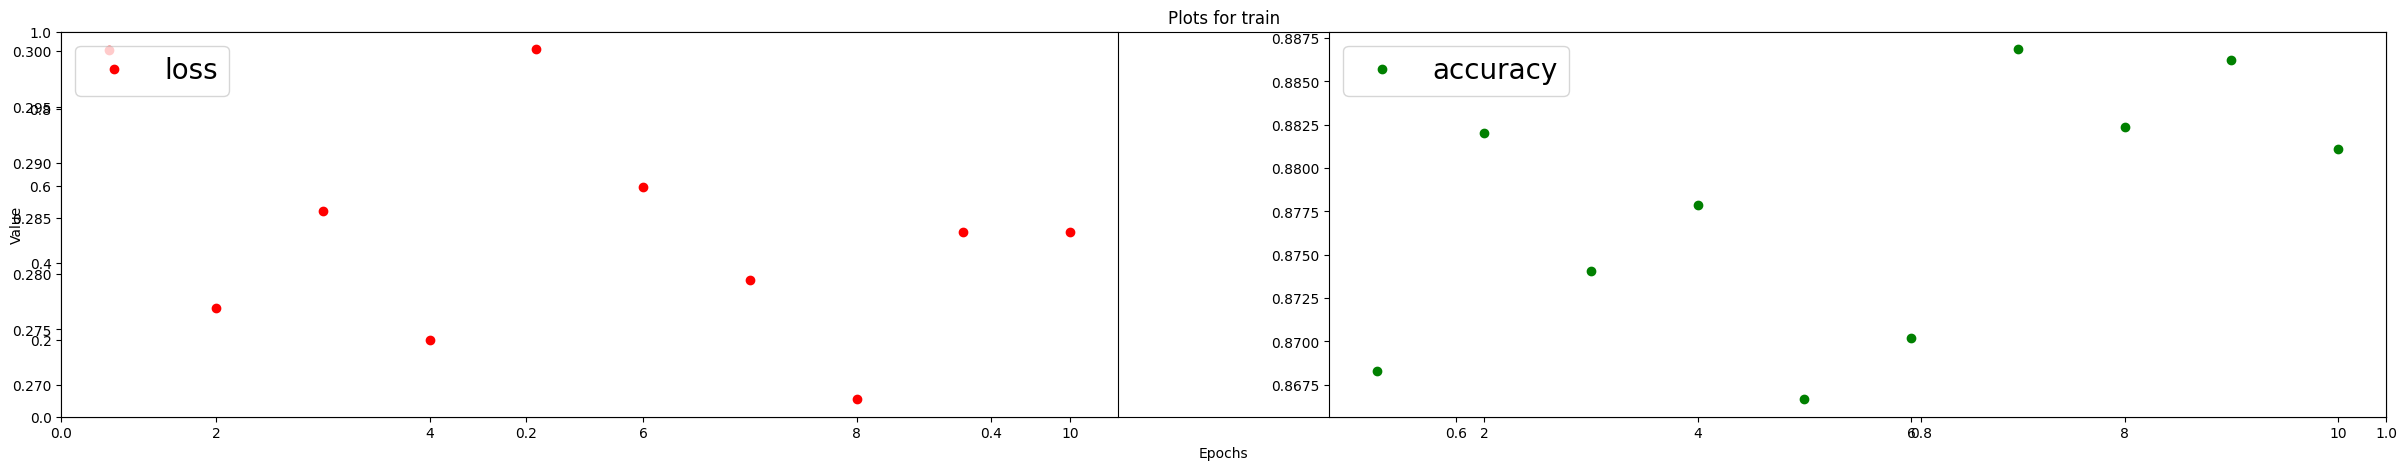

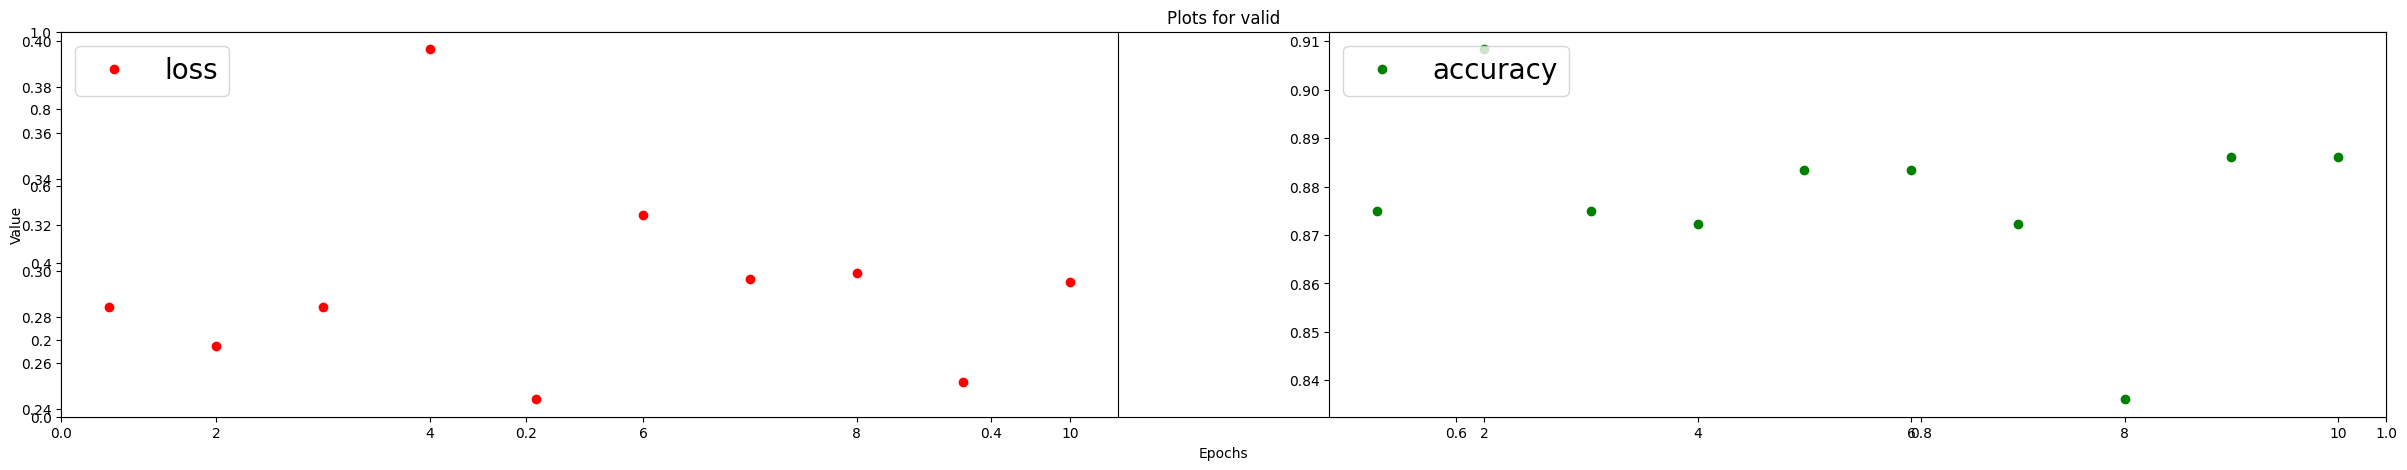

In [10]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.882452130317688, train loss : 0.2622498571872711
Epoch : 1, val_accuracy : 0.862500011920929, val_loss : 0.2822422385215759
Epoch : 2, train accuracy : 0.9086540937423706, train loss : 0.22260808944702148
Epoch : 2, val_accuracy : 0.8374999165534973, val_loss : 0.2828395664691925
Epoch : 3, train accuracy : 0.8901444673538208, train loss : 0.2559627592563629
Epoch : 3, val_accuracy : 0.8958332538604736, val_loss : 0.2813541293144226
Epoch : 4, train accuracy : 0.9043271541595459, train loss : 0.22470241785049438
Epoch : 4, val_accuracy : 0.90625, val_loss : 0.19662657380104065
Epoch : 5, train accuracy : 0.9048079252243042, train loss : 0.22926616668701172
Epoch : 5, val_accuracy : 0.8979166150093079, val_loss : 0.24493904411792755
Epoch : 6, train accuracy : 0.8887021541595459, train loss : 0.2437441647052765
Epoch : 6, val_accuracy : 0.8687500357627869, val_loss : 0.25562232732772827
Epoch : 7, train accuracy : 0.8942

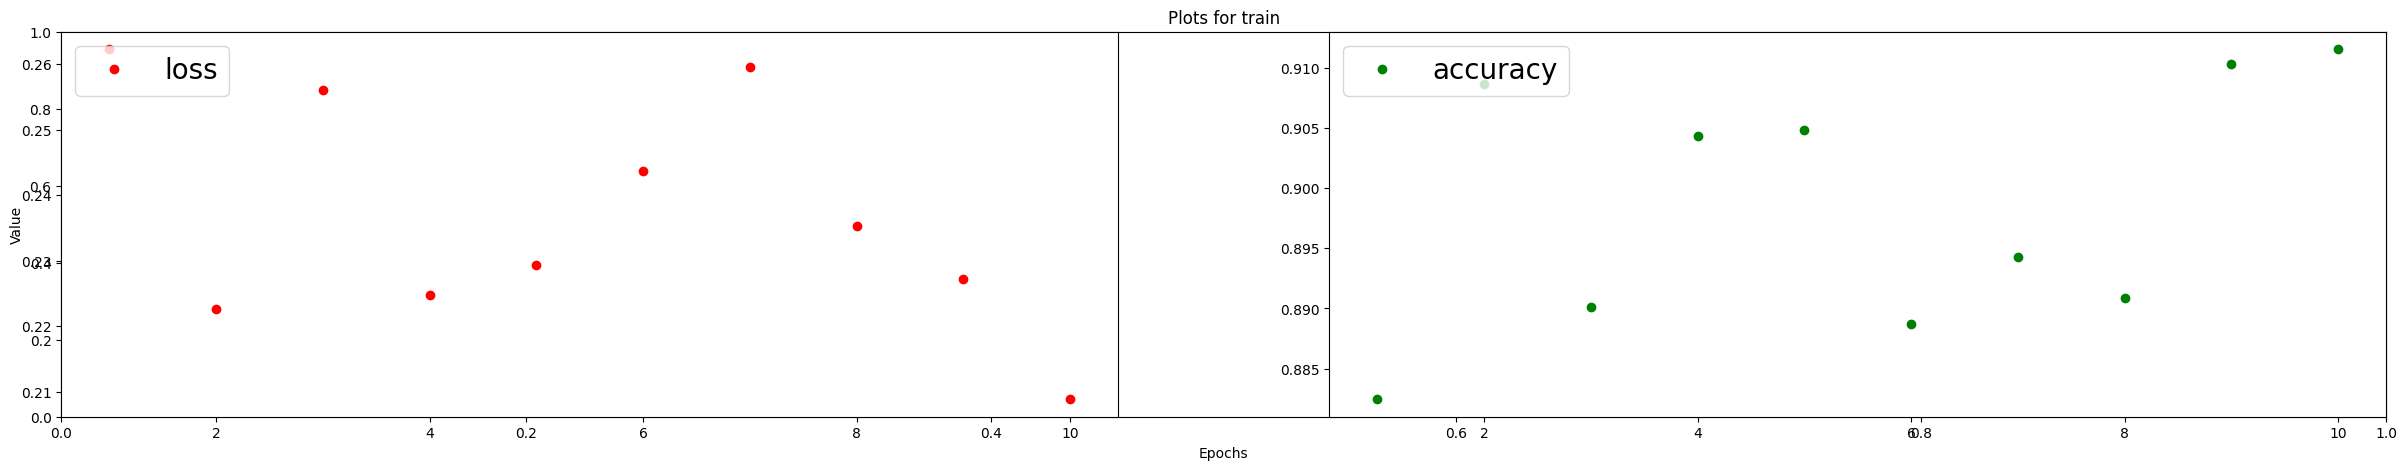

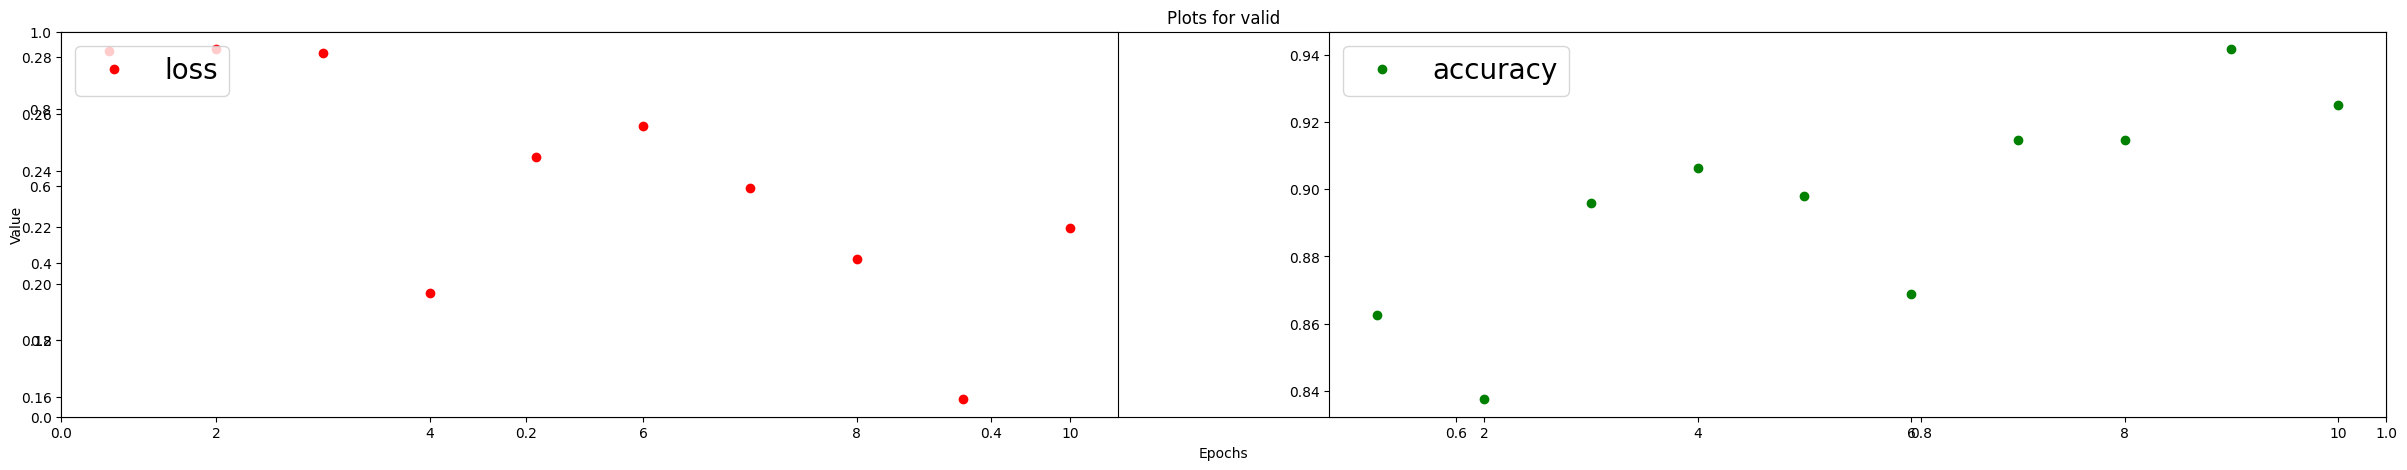

In [11]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.9153848886489868, train loss : 0.19511306285858154
Epoch : 1, val_accuracy : 0.8979166150093079, val_loss : 0.184000626206398
Epoch : 2, train accuracy : 0.9149040579795837, train loss : 0.2177836298942566
Epoch : 2, val_accuracy : 0.9083333015441895, val_loss : 0.2271393984556198
Epoch : 3, train accuracy : 0.9180291295051575, train loss : 0.2061481475830078
Epoch : 3, val_accuracy : 0.875, val_loss : 0.3217058777809143
Epoch : 4, train accuracy : 0.9324522018432617, train loss : 0.1726716160774231
Epoch : 4, val_accuracy : 0.887499988079071, val_loss : 0.28748229146003723
Epoch : 5, train accuracy : 0.904567539691925, train loss : 0.21107029914855957
Epoch : 5, val_accuracy : 0.9187500476837158, val_loss : 0.19016408920288086
Epoch : 6, train accuracy : 0.9250003099441528, train loss : 0.19546014070510864
Epoch : 6, val_accuracy : 0.9354166984558105, val_loss : 0.2016317993402481
Epoch : 7, train accuracy : 0.9076925

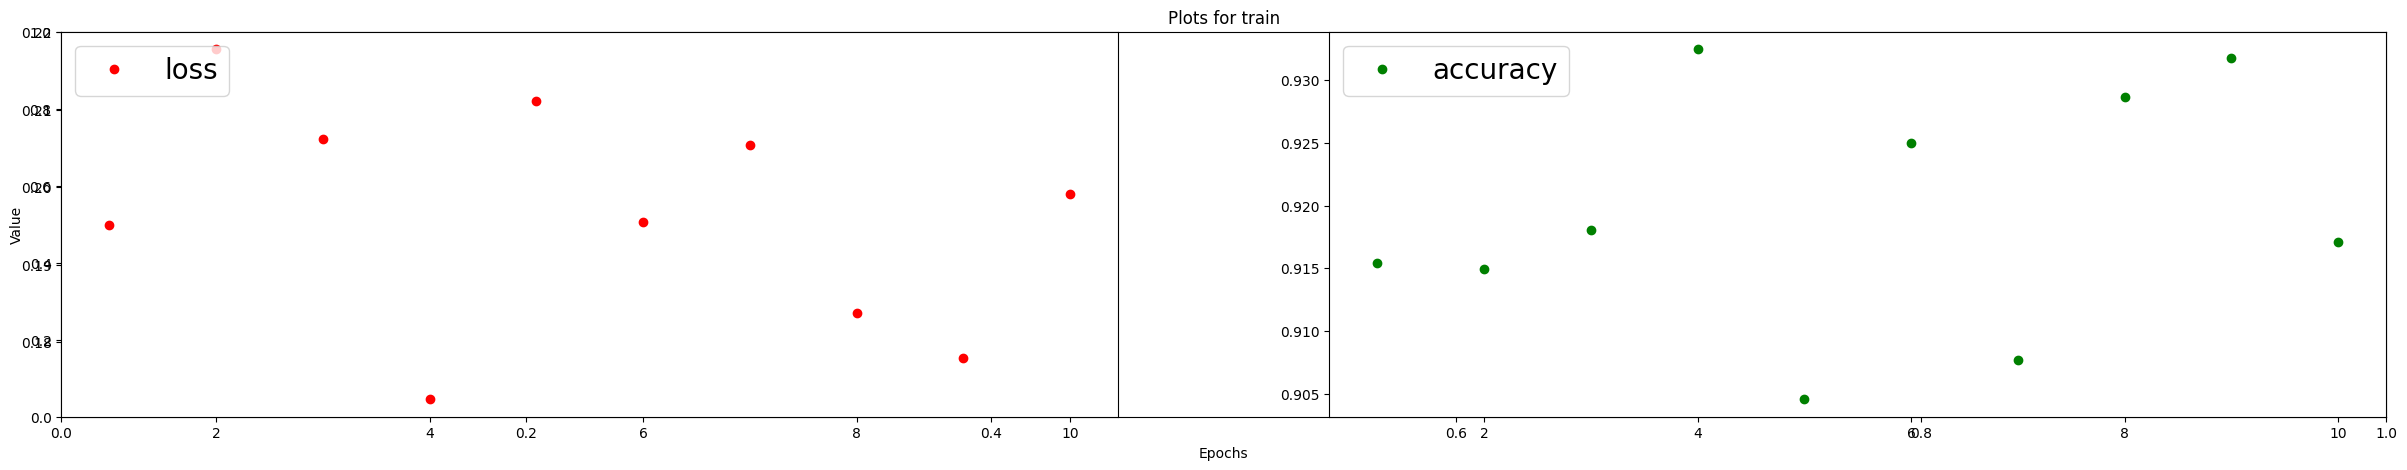

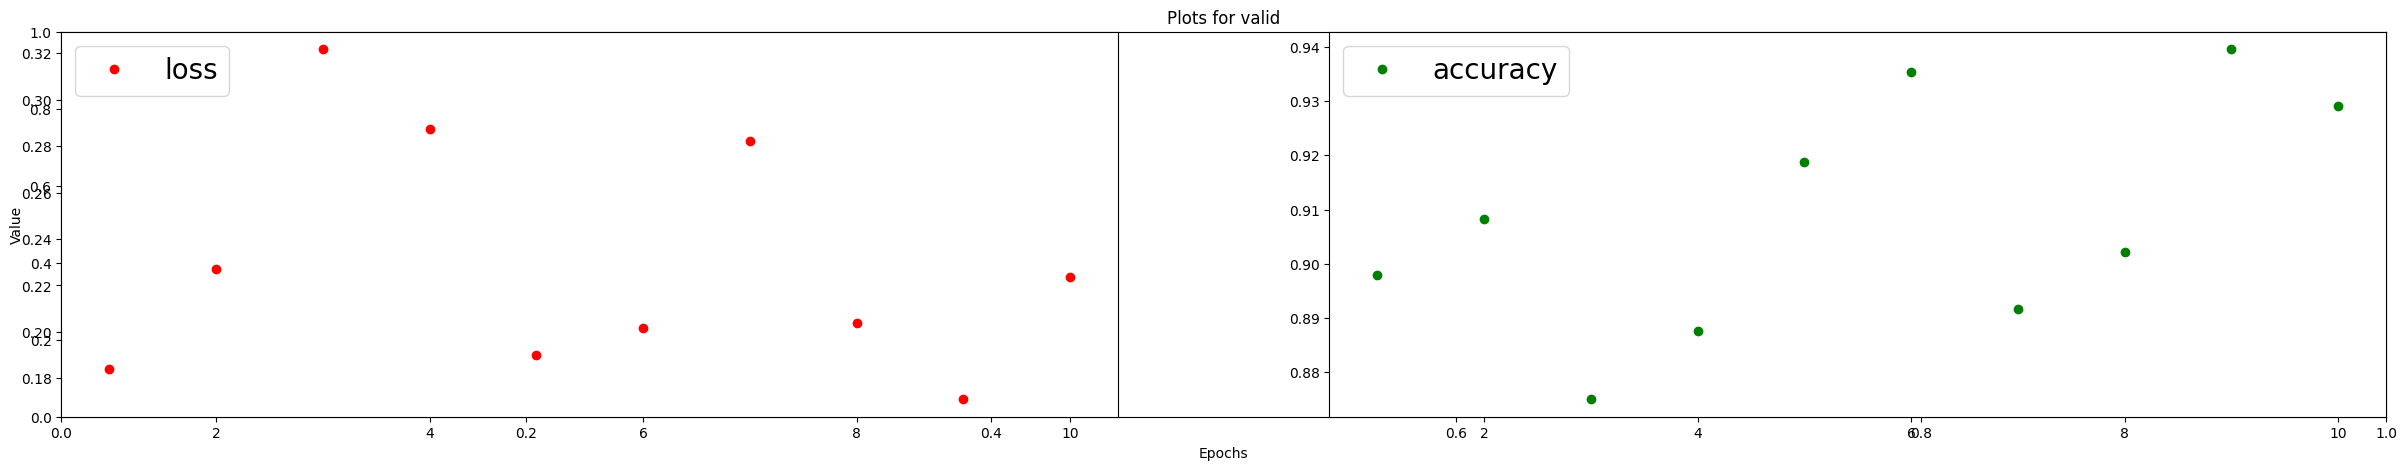

In [12]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9096156358718872, train loss : 0.21749965846538544
Epoch : 1, val_accuracy : 0.9041666388511658, val_loss : 0.2477424591779709
Epoch : 2, train accuracy : 0.9149041175842285, train loss : 0.1985580325126648
Epoch : 2, val_accuracy : 0.8895833492279053, val_loss : 0.2917063236236572
Epoch : 3, train accuracy : 0.9206733703613281, train loss : 0.18538908660411835
Epoch : 3, val_accuracy : 0.9020833373069763, val_loss : 0.23853905498981476
Epoch : 4, train accuracy : 0.9187502861022949, train loss : 0.18719202280044556
Epoch : 4, val_accuracy : 0.9208332896232605, val_loss : 0.16901296377182007
Epoch : 5, train accuracy : 0.9180291295051575, train loss : 0.17846651375293732
Epoch : 5, val_accuracy : 0.9479166269302368, val_loss : 0.16913871467113495
Epoch : 6, train accuracy : 0.9213945269584656, train loss : 0.18958567082881927
Epoch : 6, val_accuracy : 0.90625, val_loss : 0.2426445335149765
Epoch : 7, train accuracy : 0

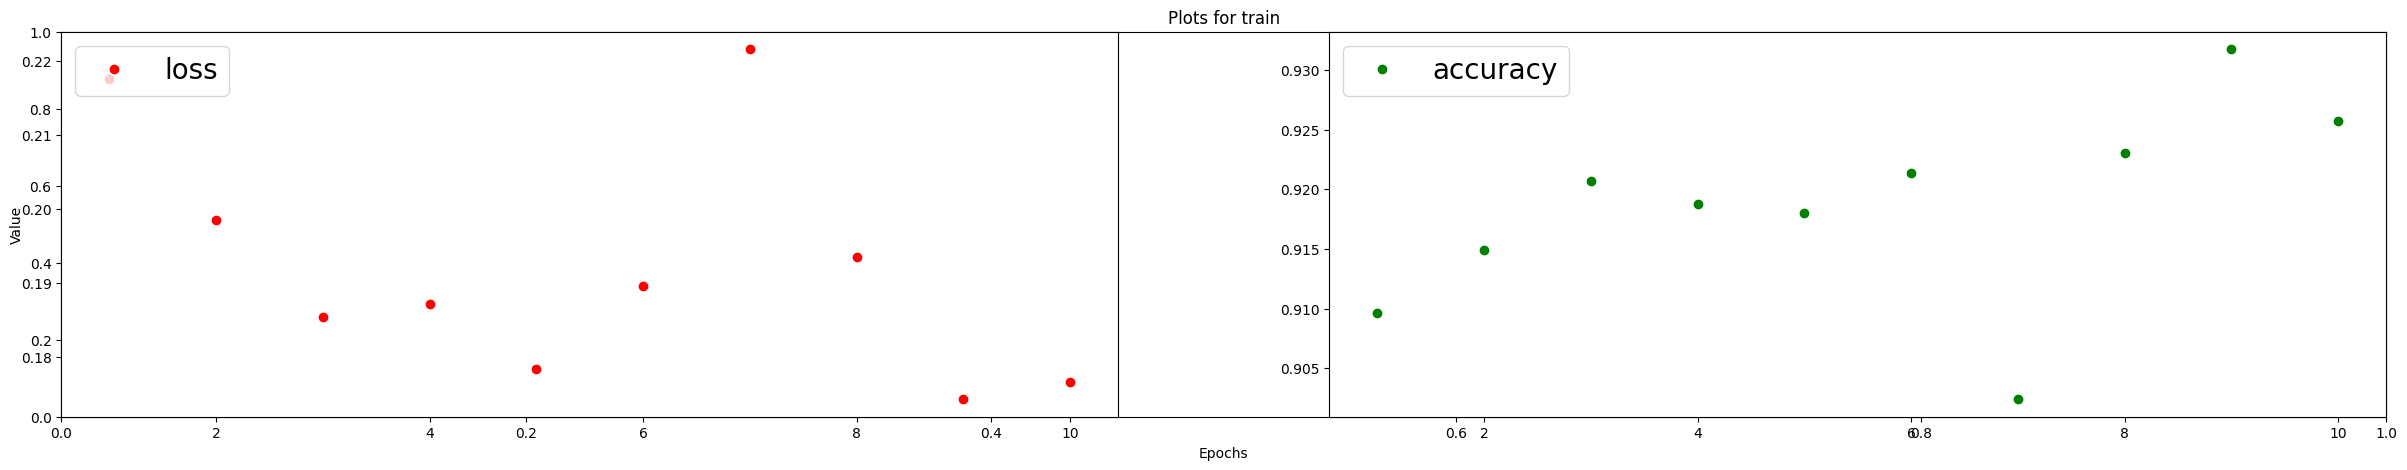

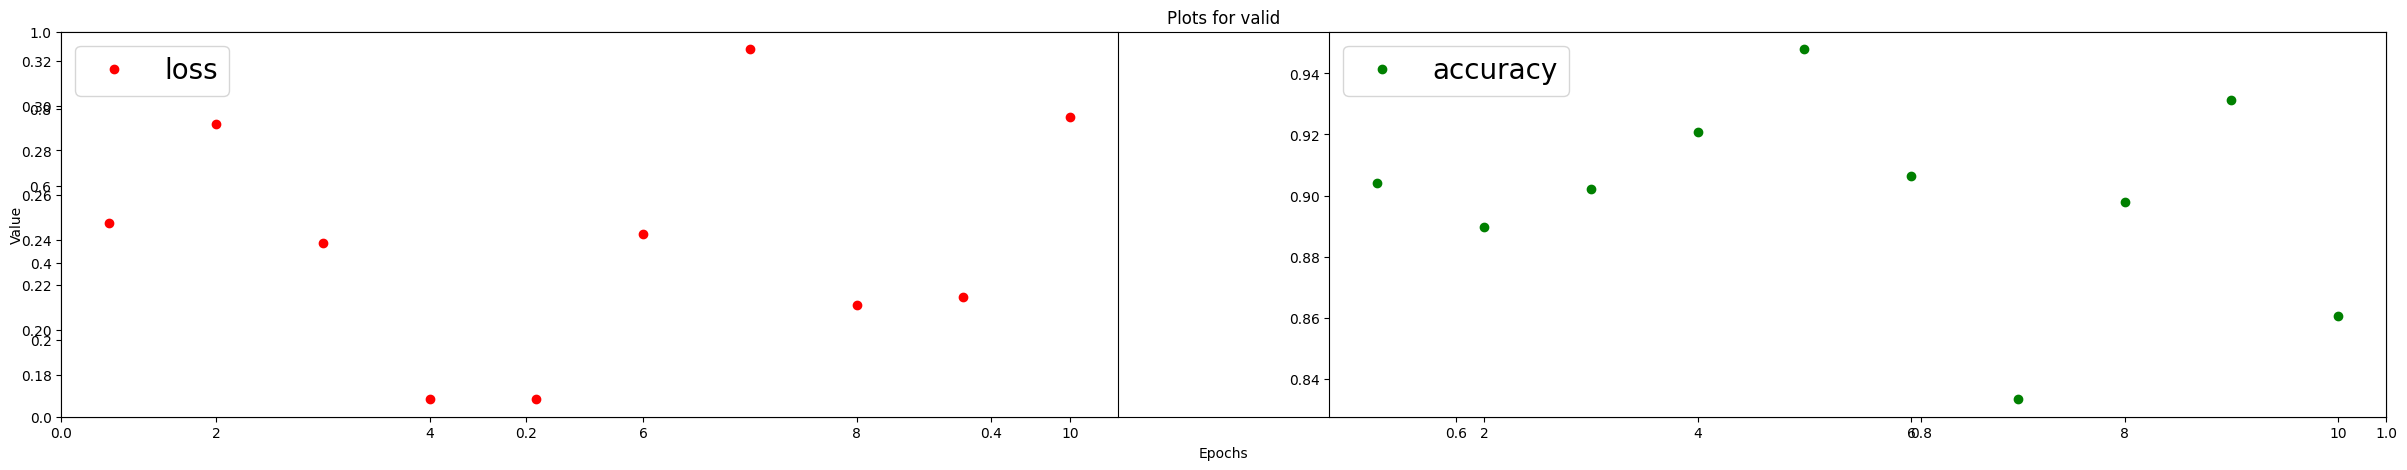

In [13]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.9209523797035217, train loss : 0.1757623553276062
Epoch : 1, val_accuracy : 0.9191666841506958, val_loss : 0.2685399055480957
Epoch : 2, train accuracy : 0.9219575524330139, train loss : 0.1801760345697403
Epoch : 2, val_accuracy : 0.9666666984558105, val_loss : 0.1528162807226181
Epoch : 3, train accuracy : 0.9339152574539185, train loss : 0.1610889881849289
Epoch : 3, val_accuracy : 0.8908333778381348, val_loss : 0.35214412212371826
Epoch : 4, train accuracy : 0.9451850056648254, train loss : 0.14216727018356323
Epoch : 4, val_accuracy : 0.9391666650772095, val_loss : 0.1834201067686081
Epoch : 5, train accuracy : 0.9358200430870056, train loss : 0.15903674066066742
Epoch : 5, val_accuracy : 0.9258333444595337, val_loss : 0.16922235488891602
Epoch : 6, train accuracy : 0.9415344595909119, train loss : 0.15450668334960938
Epoch : 6, val_accuracy : 0.9258333444595337, val_loss : 0.2884571850299835
Epoch : 7, train accur

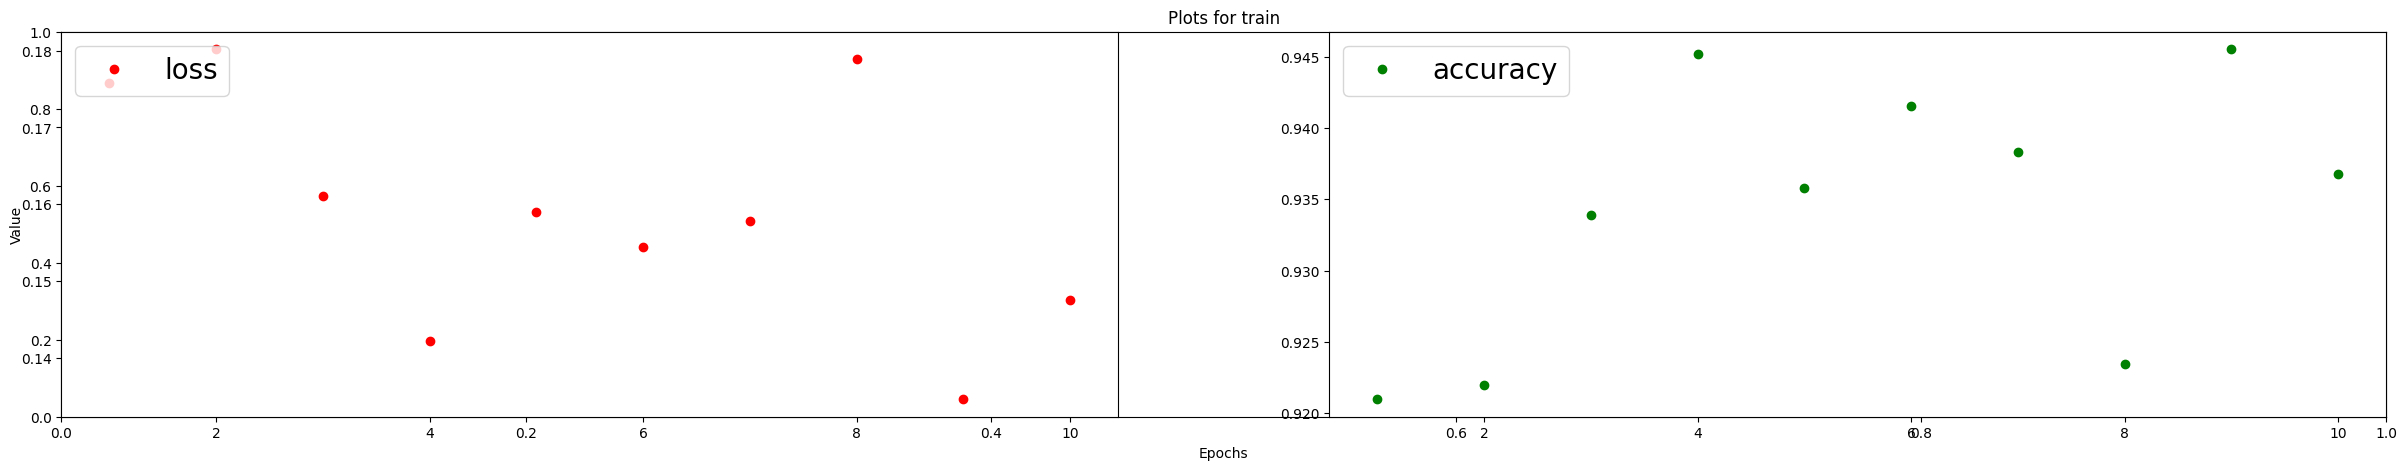

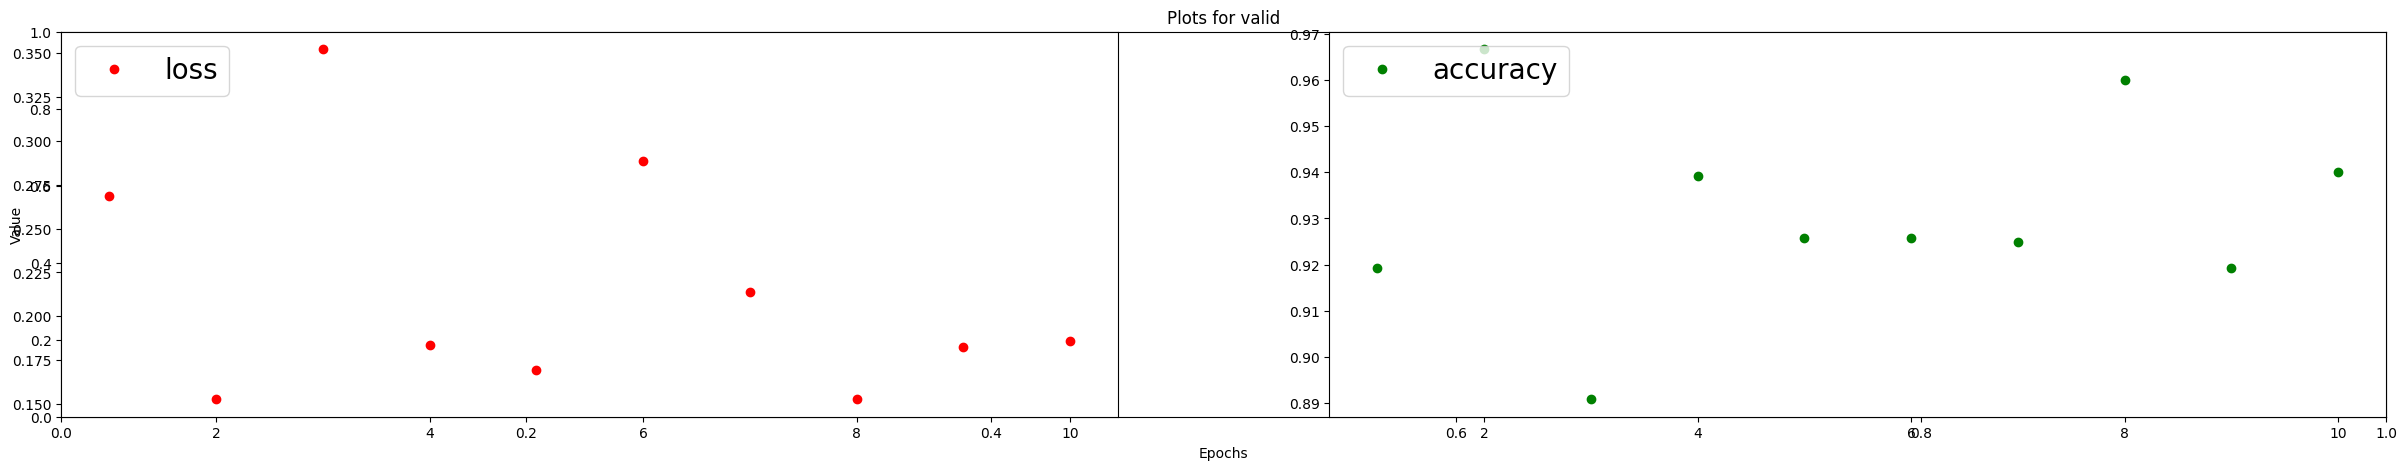

In [14]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9322221875190735, train loss : 0.16678699851036072
Epoch : 1, val_accuracy : 0.9325000047683716, val_loss : 0.22572633624076843
Epoch : 2, train accuracy : 0.9274603724479675, train loss : 0.15755875408649445
Epoch : 2, val_accuracy : 0.9466667175292969, val_loss : 0.1869346648454666
Epoch : 3, train accuracy : 0.9510582089424133, train loss : 0.13080859184265137
Epoch : 3, val_accuracy : 0.8700000047683716, val_loss : 0.2177211046218872
Epoch : 4, train accuracy : 0.9453439712524414, train loss : 0.12221160531044006
Epoch : 4, val_accuracy : 0.940000057220459, val_loss : 0.13668867945671082
Epoch : 5, train accuracy : 0.9402115941047668, train loss : 0.15040481090545654
Epoch : 5, val_accuracy : 0.9049999713897705, val_loss : 0.26329347491264343
Epoch : 6, train accuracy : 0.9495237469673157, train loss : 0.12074339389801025
Epoch : 6, val_accuracy : 0.9249999523162842, val_loss : 0.18085378408432007
Epoch : 7, train 

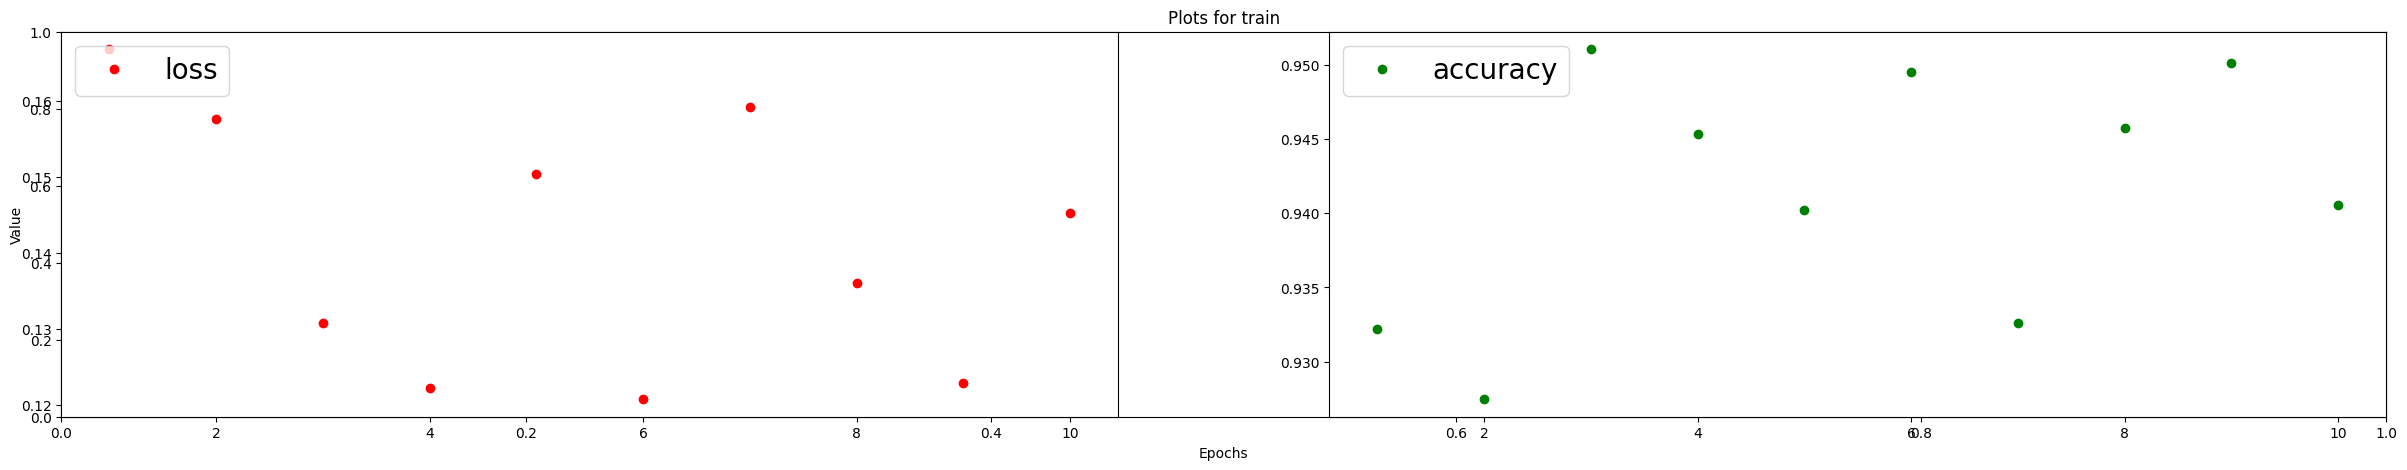

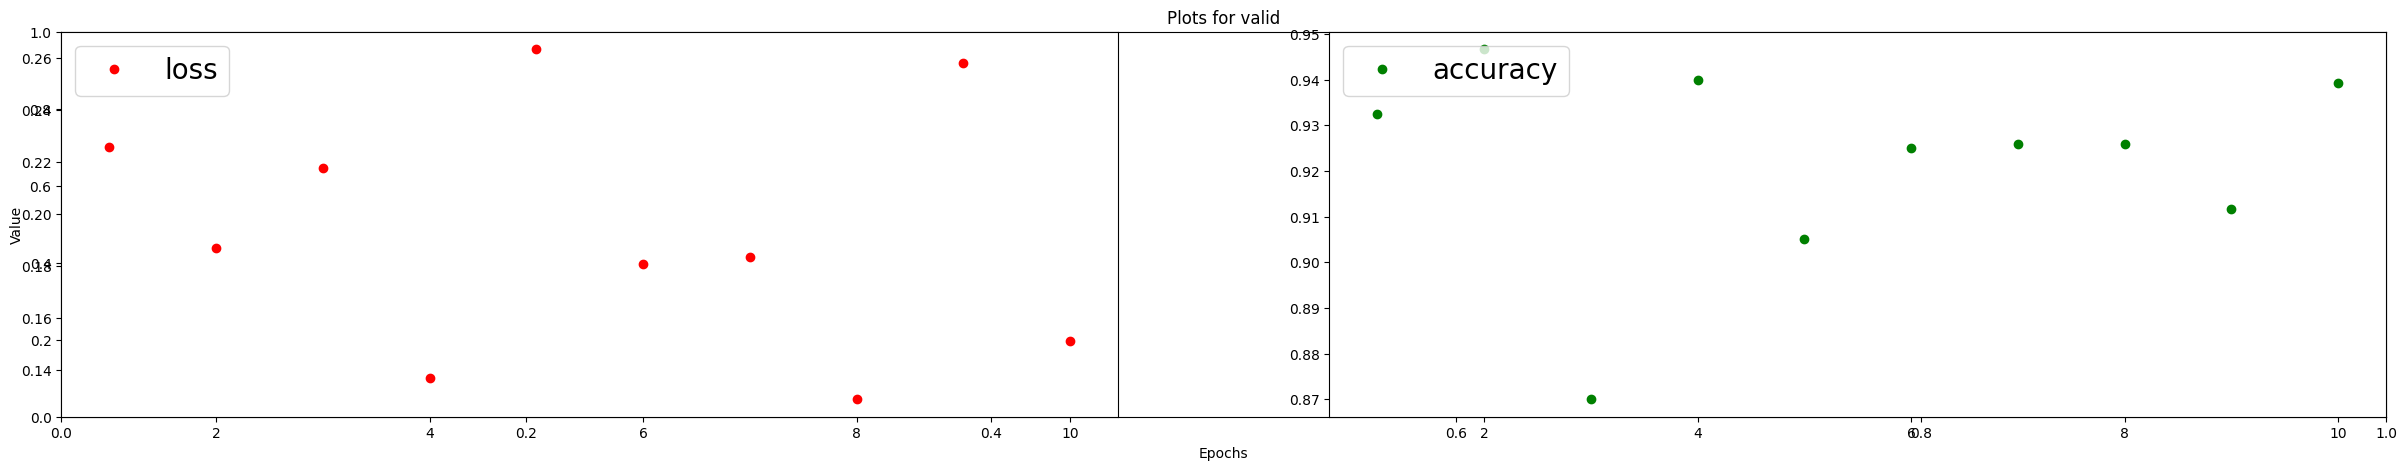

In [15]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.928783118724823, train loss : 0.15644316375255585
Epoch : 1, val_accuracy : 0.9458333253860474, val_loss : 0.17354226112365723
Epoch : 2, train accuracy : 0.9443916082382202, train loss : 0.12454545497894287
Epoch : 2, val_accuracy : 0.9600000381469727, val_loss : 0.15847958624362946
Epoch : 3, train accuracy : 0.9503173232078552, train loss : 0.13372652232646942
Epoch : 3, val_accuracy : 0.9333333969116211, val_loss : 0.19193442165851593
Epoch : 4, train accuracy : 0.9512697458267212, train loss : 0.12885825335979462
Epoch : 4, val_accuracy : 0.8975000381469727, val_loss : 0.2736464738845825
Epoch : 5, train accuracy : 0.9520106315612793, train loss : 0.1295584887266159
Epoch : 5, val_accuracy : 0.8908333778381348, val_loss : 0.2750411629676819
Epoch : 6, train accuracy : 0.95333331823349, train loss : 0.1250615268945694
Epoch : 6, val_accuracy : 0.9391666650772095, val_loss : 0.1836206316947937
Epoch : 7, train accur

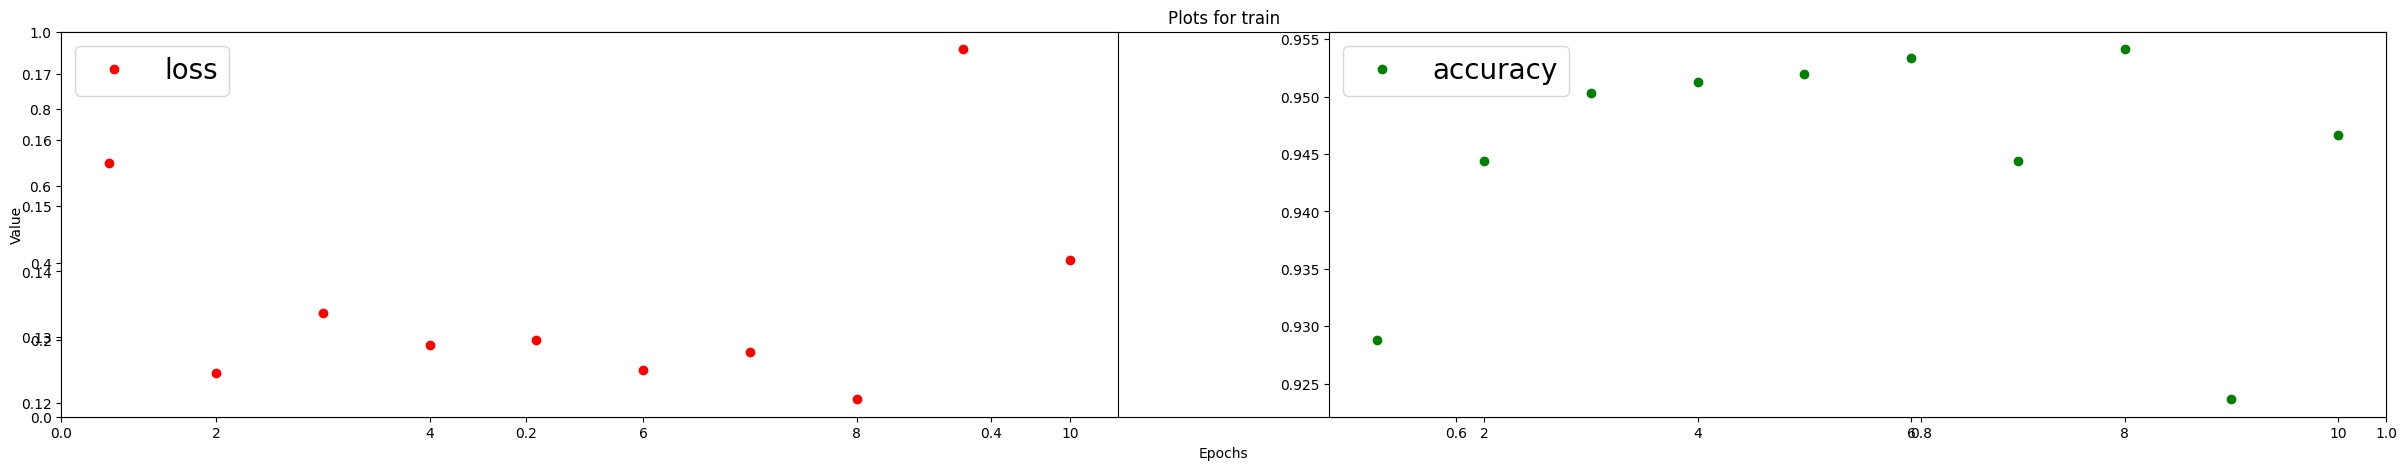

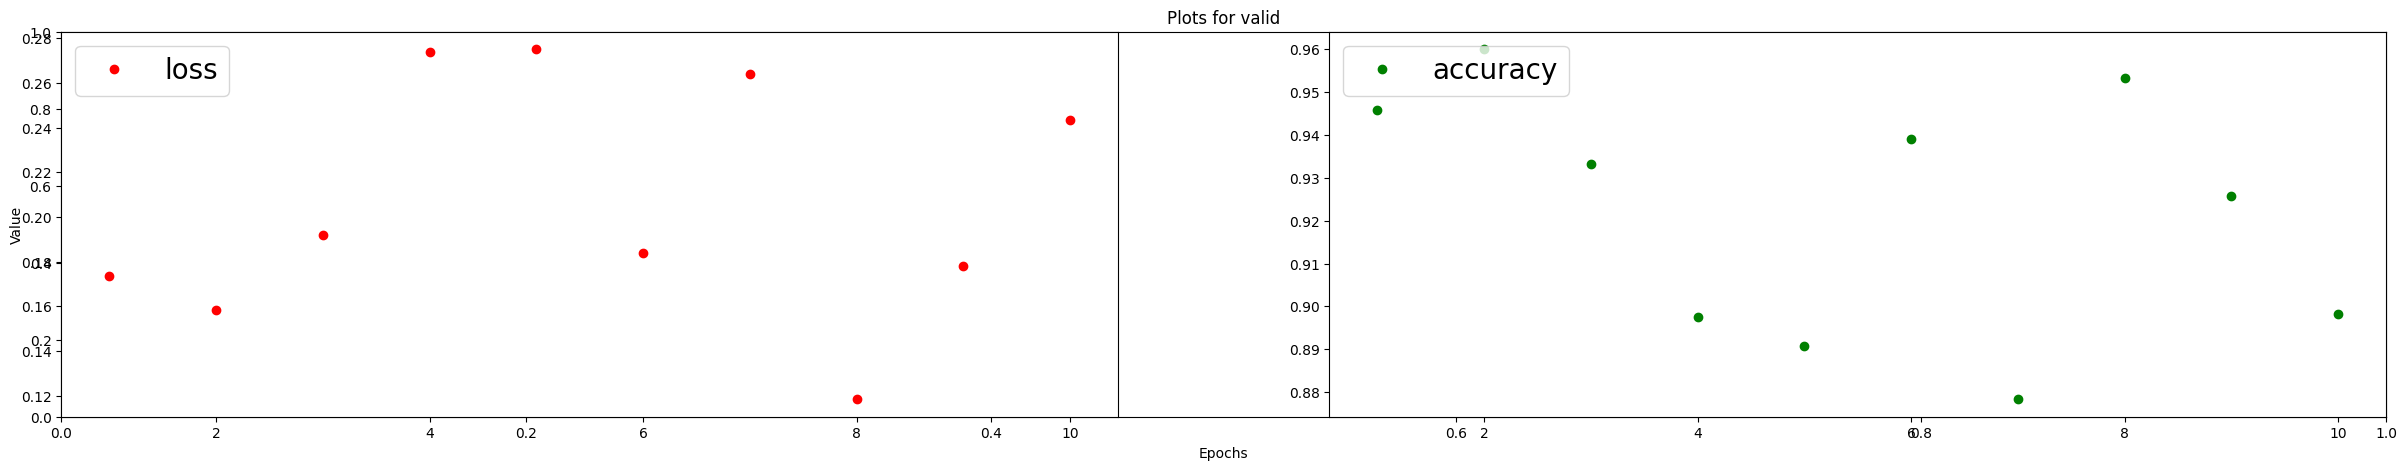

In [16]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [17]:
rose_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],rose_probs))
prob = list(map(lambda x: x[1],rose_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,610,0.999773
1,1333,0.003508
2,638,0.908140
3,1357,0.827203
4,601,0.814617
...,...,...
139,627,0.714928
140,592,0.380475
141,608,0.995937
142,1312,0.003313


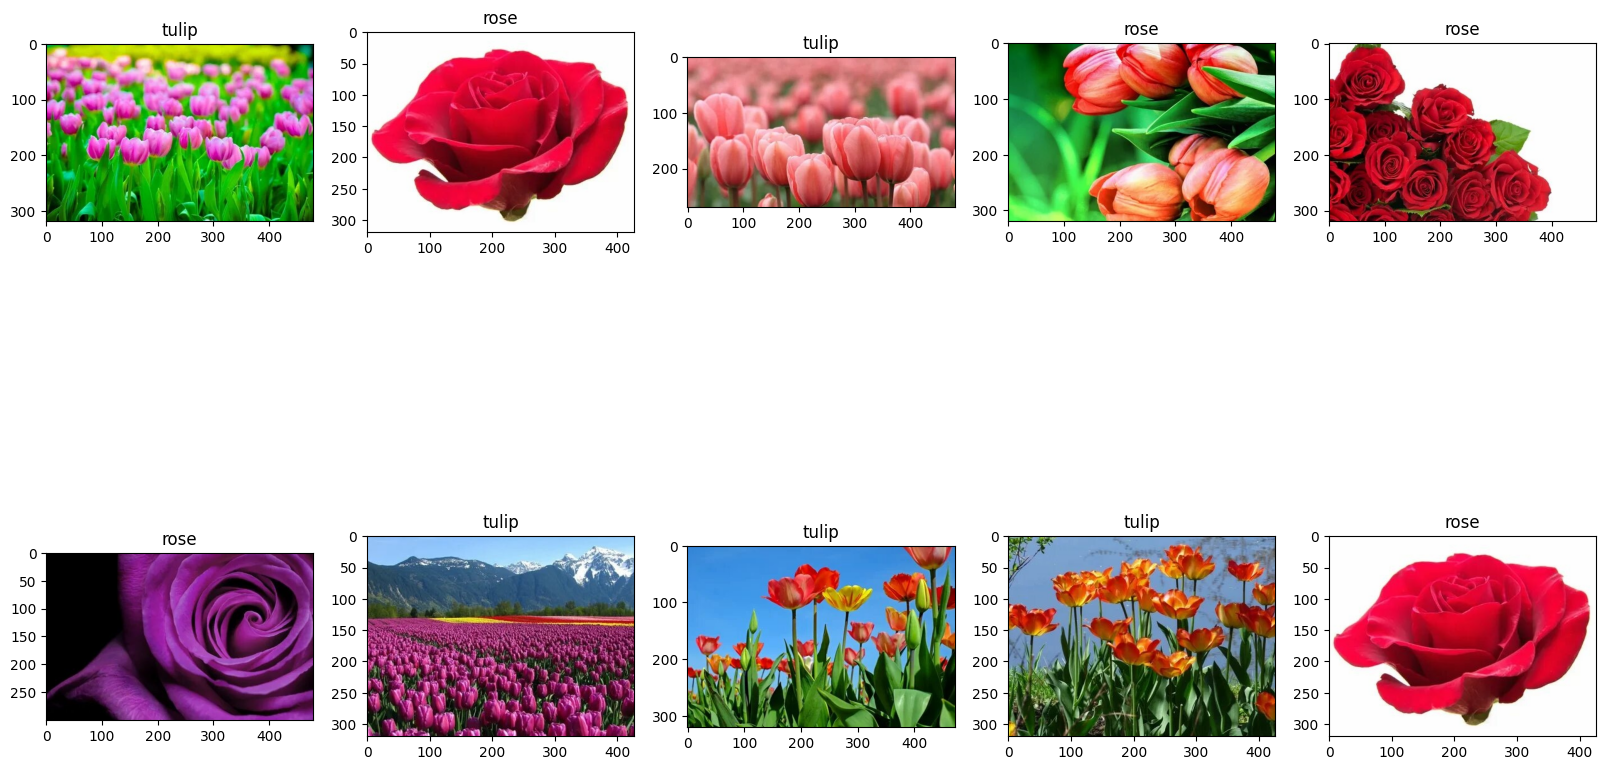

In [19]:
class_ = {0: 'tulip', 1: 'rose'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)

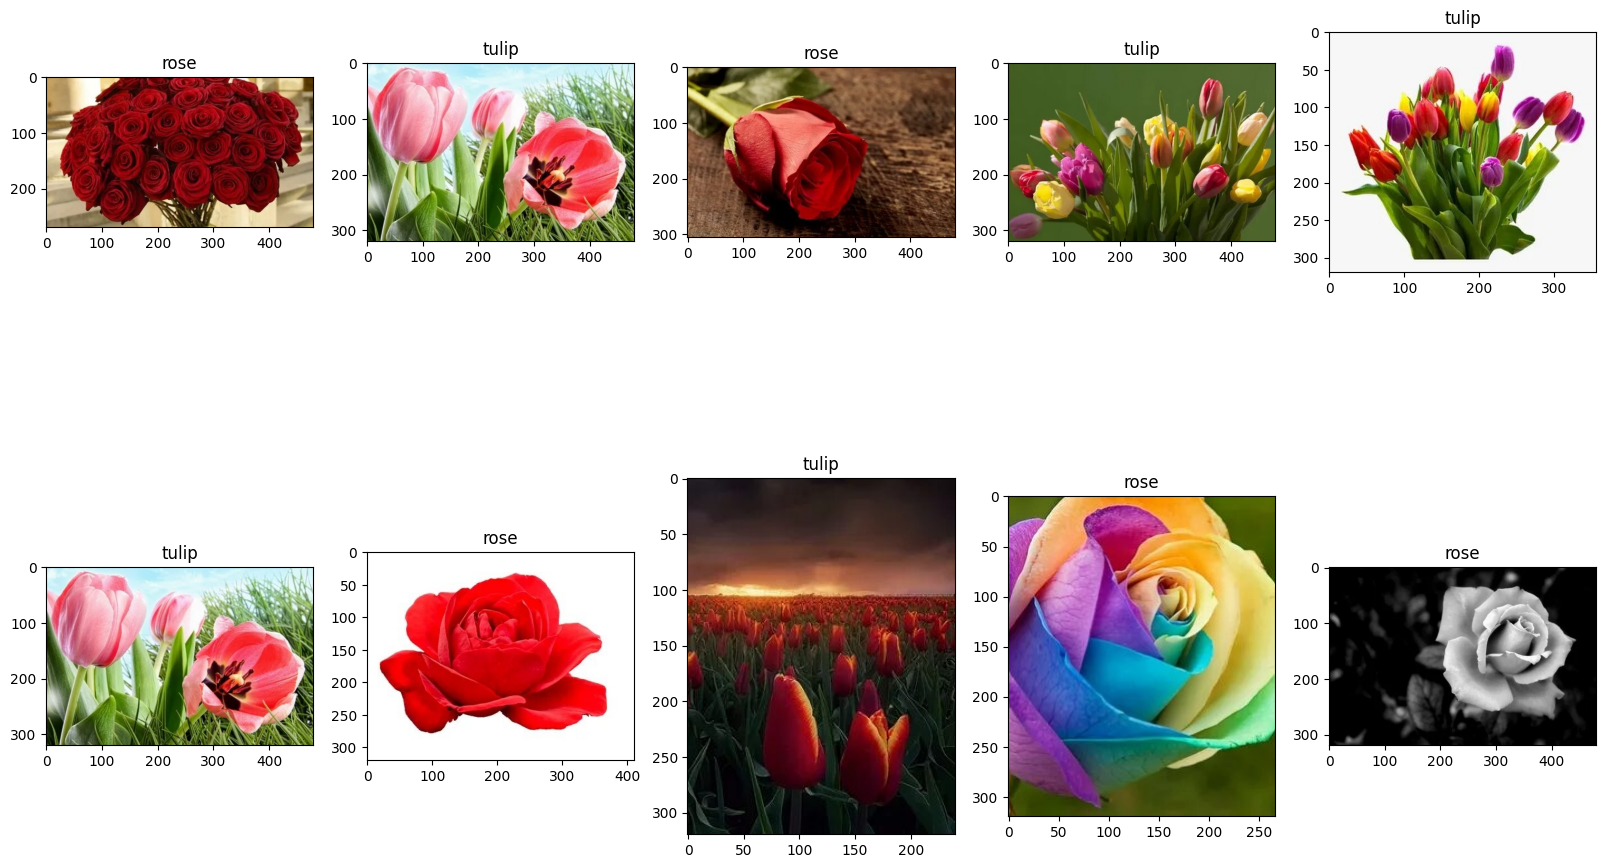

In [20]:
torch.save(model.state_dict(), 'ConvNetModel.pth')

loaded_model = ConvNet().to(device)
loaded_model.load_state_dict(torch.load('ConvNetModel.pth'))
loaded_model.eval()

tulip_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tulip_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],tulip_probs))
prob = list(map(lambda x: x[1],tulip_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'tulip', 1: 'rose'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)